Uncomment this section if imports below fail

In [4]:

# %pip install tensorflow
# %pip install keras
# %pip install matplotlib
# %pip install opencv-python opencv-python-headless
# !pip install -U scikit-learn


In [5]:
# Get data from kaggle 
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images
# ! unzip lung-and-colon-cancer-histopathological-images.zip

#Install Seaborn
# !pip3 install seaborn 

# !pip show tensorflow

In [6]:

import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout,InputLayer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from cv2 import imread,resize
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers
import seaborn as sns

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

### Helper Functions

In [8]:
def get_model_path(classifications,name=None):
    if name is None:
        model_name = ''.join(classifications)
        model_name = model_name.replace('_','')+ '.keras'
    else:
        model_name = name + '.keras'

    i = 1
    while True:
        path = os.path.join('PastModels',model_name)
        if not os.path.exists(path):
            return os.path.join('PastModels',model_name)
        else:
            model_name = model_name.split('.')[0] + f'_{i}.keras'
            i+=1


# Data preparation
From the data set we have 5000 images from each class and to make sure that we are taking the right amount for our training and testing data we need to section this 5000x5 into evenly split training and testing data. To do this we are going to take 80% of the data for training and using the last 20% of the data for testing. This comes out to 5000*.8= 4000 images per classification for training and 5000*.2 images per classification for testing. This comes out to a total of 20,000 images to train on and 5000 images to test on. The following code will represent how that will be taken place

## Load in Data

In [9]:
# Get classifications from the strucutre of the directory
classifications = os.listdir('lung_colon_image_set')

batch_size = 32

# Load the data
data = tf.keras.utils.image_dataset_from_directory('lung_colon_image_set',class_names=classifications,shuffle=True,batch_size=batch_size,labels='inferred')

Found 25000 files belonging to 5 classes.


# Lets look at the data and see what it looks like 

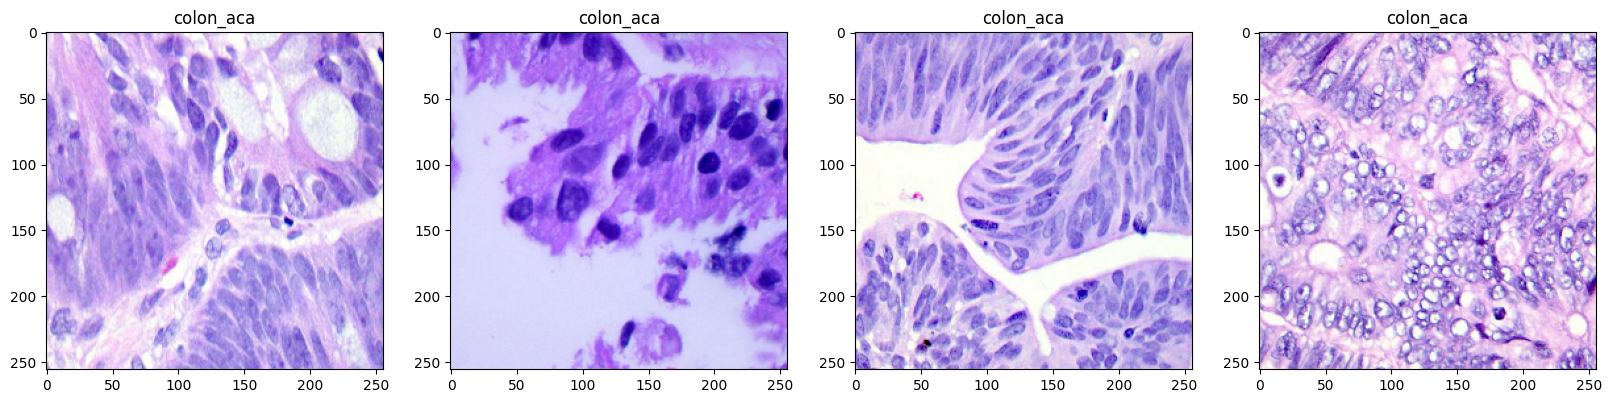

In [10]:
data_iterator = data.as_numpy_iterator()

batch = next(data_iterator)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(classifications[np.argmax(batch[1][idx], axis=-1)])
plt.show()

## Split the data

In [11]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [12]:
train_size

547

In [13]:
img = next(data_iterator)[0][0]
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [14]:

layers = [
    InputLayer(shape=img.shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(.03)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(.03)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(.03)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(.03)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(.03)),
    Dropout(.5),
    Dense(len(classifications), activation='softmax')]
    
model = Sequential(layers)


In [15]:

learning_rate = .0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [16]:
recompute = True
model_path = get_model_path(classifications,'FullModelAfterAdjustment')
if os.path.exists(model_path) and recompute == False:
    model = load_model(model_path)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,045,317 (11.62 MB)

 Trainable params: 3,044,357 (11.61 MB)

 Non-trainable params: 960 (3.75 KB)

# Training
The fun part about seeing if the model works well :smiley:

In [17]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [18]:


if os.path.exists(model_path) and recompute == False:
    print('Loaded past weights')
    hist = None
else:
    print('Fitting Model and saving weights')
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True,baseline=2)
    # hist = model.fit(train, epochs=100, validation_data=val, callbacks=[tensorboard_callback],batch_size=32)
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback,early_stopping],batch_size=batch_size)
    model.save(model_path)
    hist_json_file = 'history.json' 
    json.dump(str(hist.history), open(hist_json_file, 'w'))

Fitting Model and saving weights
Epoch 1/20
  7/547 ━━━━━━━━━━━━━━━━━━━━ 23:53 3s/step - accuracy: 0.2769 - loss: 19.5522

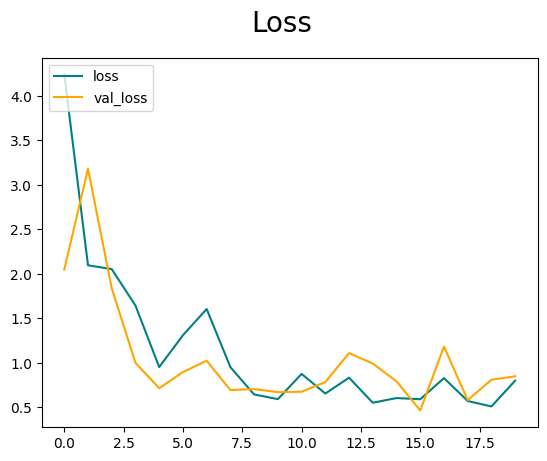

In [ ]:
if hist:
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
else:
    print('No history to plot loss')

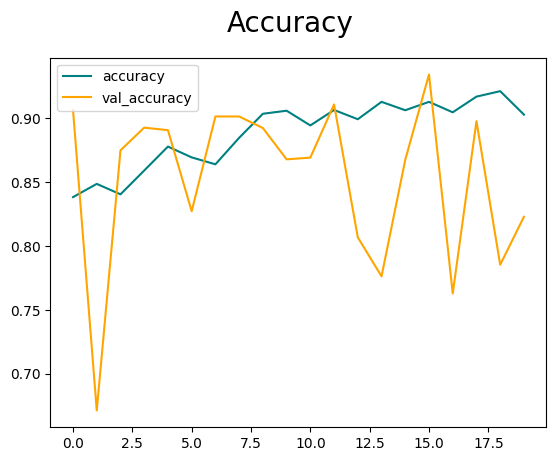

In [ ]:
if hist:
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
else:
    print('No history to plot accuracy')

Precision: 0.9629258513450623
Recall: 0.9430814385414124
Accuracy: 0.625


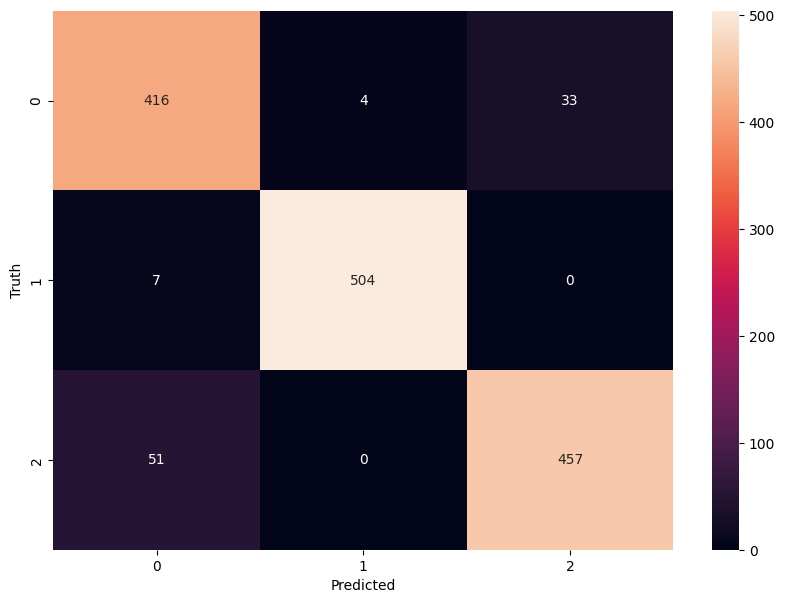

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
y_true = []
y_pred = []

for imgs, ys in test:
    # Make a prediction for the entire batch
    yhats = model.predict(imgs,verbose=0)
    
    # Convert the predictions to class indices
    yhats = np.argmax(yhats, axis=-1)

    y_true.extend([classifications[x] for x in ys.numpy().tolist()])
    y_pred.extend([classifications[x] for x in yhats.tolist()])


    
    # Update the metrics
    pre.update_state(ys, yhats)
    re.update_state(ys, yhats)
    acc.update_state(ys, yhats)

cm = confusion_matrix(y_true, y_pred)


# Print the final results
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {re.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In [ ]:
yhat = model.predict(img)

yhat

actual = 'lung_aca'
for i in range(1,5001):
    string = f'lungaca{i}.jpeg'
    img = imread(os.path.join('lung_colon_image_set',actual,string))
    img = resize(img, (256,256))
    img = np.expand_dims(img, axis=0)
    yhat = model.predict(img,verbose=0)
    max_idx = np.argmax(yhat)
    if classifications[max_idx] == actual:
        break
print(i)
print(f'predicted: {classifications[max_idx]} actual: {actual}')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
